## Table of Contents
  1. [Introduction](#introduction)
  2. [EDA: AMPATH PATIENT DATA](#eda-ampath-patient-data)
  3. [EDA: KASHA DELIVERY DATA](#eda-kasha-delivery-data)
  4. [Data Cleaning: AMPATH PATIENT DATA](#data-cleaninig-ampath-patient-data)
  5. [Feature Engineering: AMPATH PATIENT DATA](#feature-engineering-ampath-patient-data)
  6. [Data Cleaning: KASHA DELIVERY DATA](#data-cleaning-kasha-delivery-data)
  7. [Feature Engineering: KASHA DELIVERY DATA](#feature-engineering-kasha-delivery-data)

## Introduction
This notebook contains excerpts from the exploratory data analysis (EDA), data cleaning, and feature engineering steps for the AMPATH patient data and Kasha delivery data. The goal is to prepare the data for modeling and analysis.

In [45]:
! pip install -q pandas numpy matplotlib seaborn openpyxl matplotlib-venn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import warnings
from matplotlib_venn import venn2
import re

warnings.filterwarnings("ignore")

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.facecolor": "#F0F0F0",
        "axes.facecolor": "#F0F0F0",
        "figure.titlesize": 18,
        "axes.axisbelow": True,
    }
)

In [47]:
def read_file_ampath(file_path, sheet_name=0):
    """Reads data from an Excel or CSV file."""
    if file_path.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.endswith((".xls", ".xlsx")):
        return pd.read_excel(file_path, sheet_name=sheet_name)
    else:
        raise ValueError(
            "Unsupported file format. Please provide an Excel or CSV file."
        )

def read_file_ampath_patient():
    return pd.read_csv("data/AI_Predictive_Modeling_HIV_AMPATH_Data.csv")

df = read_file_ampath_patient()

## EDA AMPATH PATIENT DATA

### Patient Health Progression 

This chart shows the progression of HIV stage of the patients recorded at the beginning of their diagnosis and at the end.

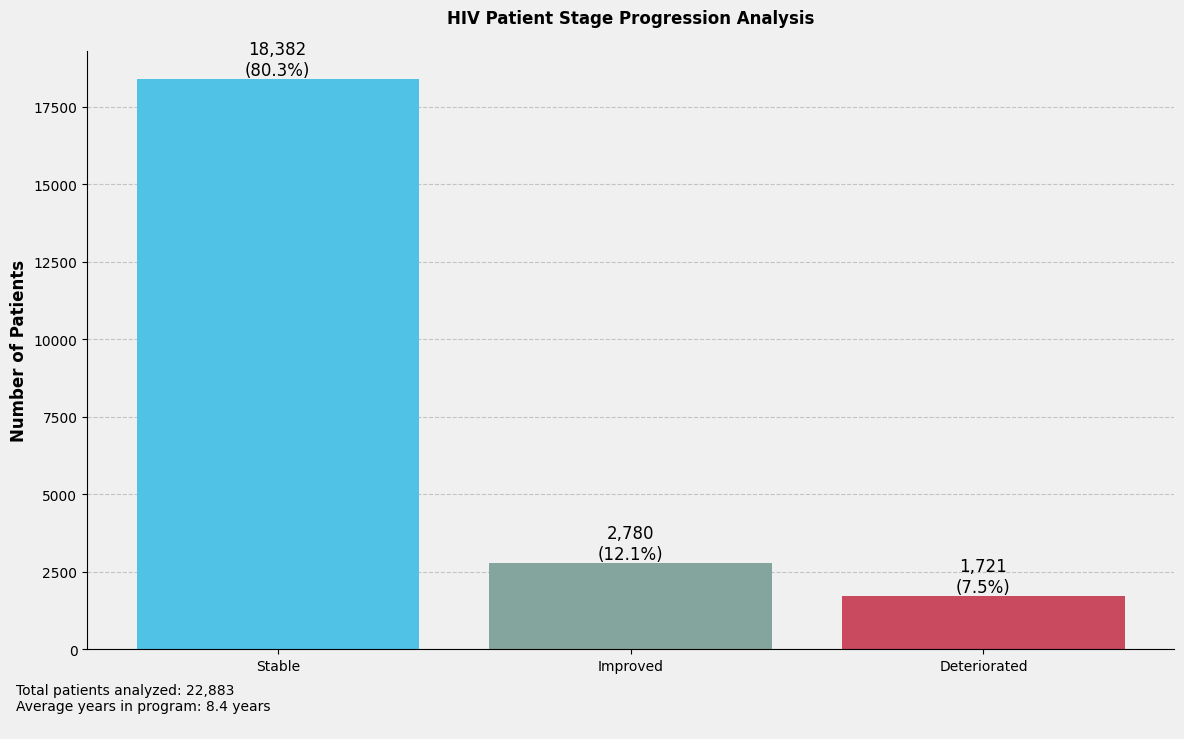

In [48]:
def analyze_patient_progression(df):
    # Convert dates and sort
    df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")
    df = df.sort_values(['patient_identifier', 'Encounter_Date'])
    
    # Remove null values and invalid entries
    df = df[df['Current_WHO_HIV_Stage'] != '\\N']
    df = df[df['Current_WHO_HIV_Stage'].notna()]
    df['Current_WHO_HIV_Stage'] = pd.to_numeric(df['Current_WHO_HIV_Stage'], errors='coerce')
    
    def get_mode_of_stages(stages):
        if len(stages) == 0:
            return np.nan
        # Return mode, if multiple modes exist, return the first one
        return stages.mode().iloc[0] if not stages.empty else np.nan

    # For each patient, get mode of first 10 and last 10 non-null stages to overcome data quality issues
    patient_stages = df.groupby('patient_identifier').agg({
        'Current_WHO_HIV_Stage': lambda x: get_mode_of_stages(x.head(10)),  # Mode of first 10
        'Encounter_Date': 'first'
    }).rename(columns={'Current_WHO_HIV_Stage': 'initial_stage', 'Encounter_Date': 'first_date'})
    
    # Get mode of last 10 stages
    last_stages = df.groupby('patient_identifier').agg({
        'Current_WHO_HIV_Stage': lambda x: get_mode_of_stages(x.tail(5)),  # Mode of last 10
        'Encounter_Date': 'last'
    }).rename(columns={'Current_WHO_HIV_Stage': 'current_stage', 'Encounter_Date': 'last_date'})
    
    patient_stages['current_stage'] = last_stages['current_stage']
    patient_stages['last_date'] = last_stages['last_date']
    
    # Only consider patients with both valid stages
    valid_stages = patient_stages.dropna(subset=['initial_stage', 'current_stage'])
    
    # Calculate time difference in years
    valid_stages['years_in_program'] = (valid_stages['last_date'] - valid_stages['first_date']).dt.total_seconds() / (365.25 * 24 * 60 * 60)
    
    # Determine outcome
    valid_stages['outcome'] = np.where(
        valid_stages['current_stage'] > valid_stages['initial_stage'], 
        'Improved',
        np.where(
            valid_stages['current_stage'] == valid_stages['initial_stage'], 
            'Stable', 
            'Deteriorated'
        )
    )
    
    # Plot
    outcome_dist = valid_stages['outcome'].value_counts()
    total_patients = len(valid_stages)
    
    plt.figure(figsize=(12, 7))
    colors = ['#50C2E5', '#84a59d', '#C9495E',]
    bars = plt.bar(outcome_dist.index, outcome_dist.values, color=colors)
    
    plt.title('HIV Patient Stage Progression Analysis', 
              pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Number of Patients')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total_patients) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{int(height):,}\n({percentage:.1f}%)',
            ha='center',
            va='bottom'
        )
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add summary text with average years in program
    avg_years = valid_stages['years_in_program'].mean()
    plt.figtext(
        0.02, -0.05,
        f'Total patients analyzed: {total_patients:,}\n'
        f'Average years in program: {avg_years:.1f} years\n',
        ha='left',
        fontsize=10
    )
    
    plt.tight_layout()
    plt.show()
    
 
    return valid_stages

# Call the function
progression_data = analyze_patient_progression(df)


### Visit Pattern Analysis
This heatmap shows when patients visit the clinic throughout a typical week, focusing on working hours from 7 AM to 6 PM.

Cleaned date range:
Earliest date: 2000-01-15 00:00:00
Latest date: 2024-10-20 00:00:00

Removed 10 invalid or future dates


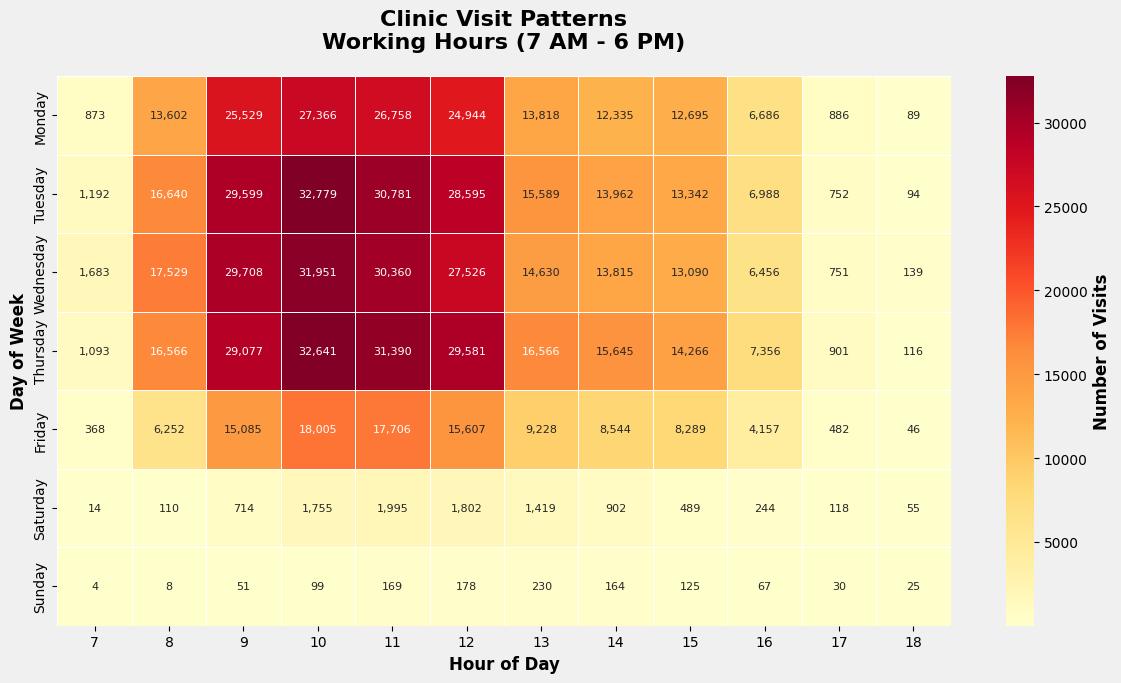

In [49]:
# Convert Encounter_Date to datetime and handle invalid dates
df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")

# Filter out future dates and very old dates (before 2000)
df_valid = df[
    (df["Encounter_Date"] <= pd.Timestamp.now())
    & (df["Encounter_Date"] >= pd.Timestamp("2000-01-01"))
]

print("Cleaned date range:")
print("Earliest date:", df_valid["Encounter_Date"].min())
print("Latest date:", df_valid["Encounter_Date"].max())
print(f"\nRemoved {len(df) - len(df_valid)} invalid or future dates")


# For the visit pattern analysis, let's use only valid dates
df_valid = df.dropna(subset=["Encounter_Date"])

# Extract day and hour info
df_valid["day_of_week"] = df_valid["Encounter_Date"].dt.day_name()
df_valid["hour_of_day"] = df_valid["Encounter_Date"].dt.hour
# Calculate visit frequency by day and hour
visit_patterns = (
    df_valid.groupby(["day_of_week", "hour_of_day"]).size().unstack(fill_value=0)
)

# Reorder days for better visualization
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
visit_patterns = visit_patterns.reindex(days_order)

# Filter to show only clinic hours (7-18)
visit_patterns = visit_patterns.loc[:, 7:18]

# Create heatmap with improved styling
plt.figure(figsize=(12, 7))
sns.heatmap(
    visit_patterns,
    cmap="YlOrRd",
    annot=True,
    fmt=",d",  # Format numbers with comma separator
    annot_kws={"size": 8},  # Smaller font for numbers
    cbar_kws={"label": "Number of Visits"},
    linewidths=0.5,
)

plt.title("Clinic Visit Patterns\nWorking Hours (7 AM - 6 PM)", pad=20)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

## EDA Kasha Delivery Data

### HIV Patient Distribution by County Analysis

This analysis examines the distribution of HIV patients across different counties.


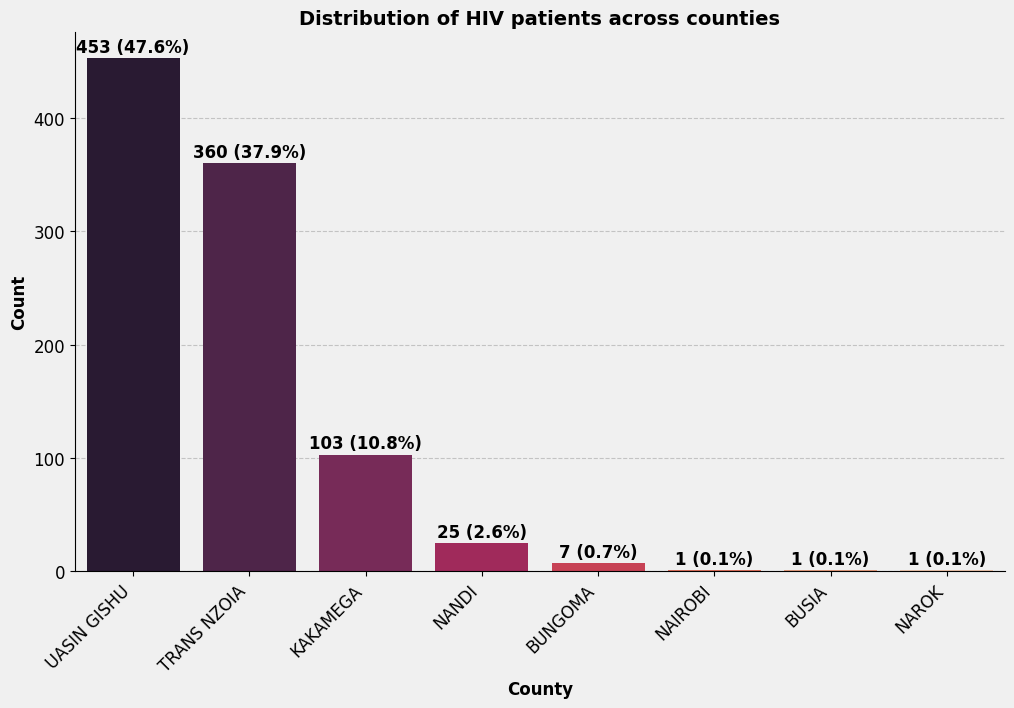

In [50]:
def plot_bar_chart(df_ampath, column, title):
    """Plots a bar chart for patient demographics with total counts and percentages."""
    plt.figure(figsize=(12, 7))
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, 'count']

    ax = sns.barplot(x=column, y='count', hue=column, data=data, dodge=False, legend=False, palette='rocket')

    total_count = data['count'].sum()

    # Customize spines (remove the box look)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    file_path = "data/Patient List.xlsx"
    sheet_name = 0  # Change if needed

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_bar_chart(df_ampath, "County", "Distribution of HIV patients across counties")

### Delivery Performance Analysis

This chart shows how well Kasha is able to perform deliveries of the ART medication to the patients.

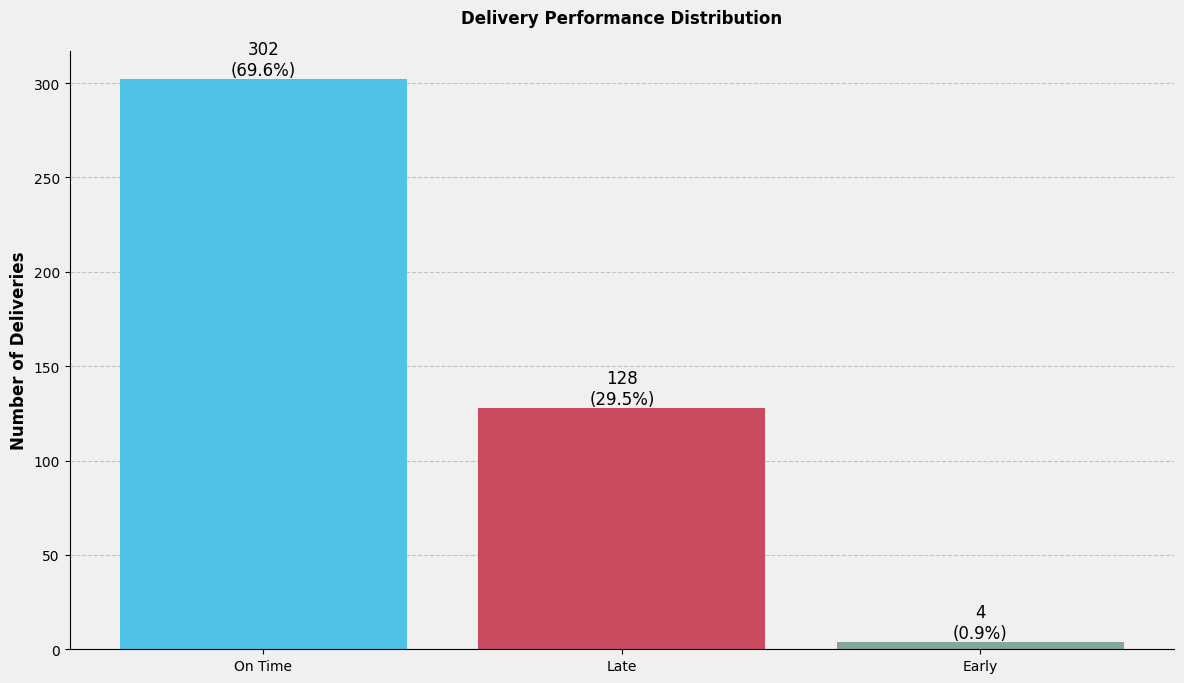

In [51]:
def analyze_delivery_performance(df_ampath):
    # Convert dates to datetime with proper format
    df_ampath['Due_Date'] = pd.to_datetime(df_ampath['Due Date'], errors="coerce")
    # Convert Completed Date (format: DD/MM/YY HH:MM:SS)
    df_ampath['Completed_Date'] = pd.to_datetime(df_ampath['Completed Date'], format='%d/%m/%y %H:%M:%S', errors="coerce")
    
    # Calculate days difference directly
    df_ampath['Days_Difference'] = (df_ampath['Completed_Date'] - df_ampath['Due_Date']).dt.days
    
    # Categorize deliveries
    df_ampath['Delivery_Status'] = pd.cut(
        df_ampath['Days_Difference'],
        bins=[-float('inf'), -1, 0, float('inf')],
        labels=['Early', 'On Time', 'Late']
    )
    
    # Delivery Performance Distribution
    delivery_counts = df_ampath['Delivery_Status'].value_counts()
    colors = {'On Time': '#50C2E5', 'Late': '#C9495E', 'Early': '#84a59d'}
    
    plt.figure(figsize=(12, 7))
    bars = plt.bar(delivery_counts.index, delivery_counts.values, color=[colors[x] for x in delivery_counts.index])
    
    # Add value labels
    total = len(df_ampath.dropna(subset=['Delivery_Status']))
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    plt.title('Delivery Performance Distribution', pad=20, fontsize=12, fontweight='bold')
    plt.ylabel('Number of Deliveries')
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Load your dataset and call the function
file_path = "data/Ampath Deliveries.xlsx"
sheet_name = 0 

df_ampath = read_file_ampath(file_path, sheet_name)  # Assuming this function is already defined
analyze_delivery_performance(df_ampath)


## Data Cleaninig: AMPATH PATIENT DATA

#### Identify Columns with High Missing Values
In this step, we aim to identify columns with more than 50% missing values. These columns will be evaluated to decide whether they should be removed or retained based on their relevance to predicting treatment interruption.



In [52]:
ampath_patient_data = pd.read_csv("data/AI_Predictive_Modeling_HIV_AMPATH_Data.csv")
ampath_patient_data.replace(r"\N", pd.NA, inplace=True)

# Sort by person_id and Encounter_Date (ensure Encounter_Date is datetime)
ampath_patient_data['Encounter_Date'] = pd.to_datetime(ampath_patient_data['Encounter_Date'], errors='coerce')

# Sort by person_id and Encounter_Date to ensure chronological order
ampath_patient_data = ampath_patient_data.sort_values(by=['person_id', 'Encounter_Date'], ascending=[True, True])

# Drop duplicates based on person_id and Encounter_Date, keeping the last row
ampath_patient_data_cleaned = ampath_patient_data.drop_duplicates(subset=['person_id', 'Encounter_Date'], keep='last')

ampath_patient_data_cleaned.reset_index(drop=True, inplace=True)

Columns with >50% missing values:
CD4_Count                          93.354101
Is_PMTCT                           96.066726
Viral_Load                         84.636837
Education_Level                    96.402150
Classification_Of_Malnutrition    100.000000
dtype: float64


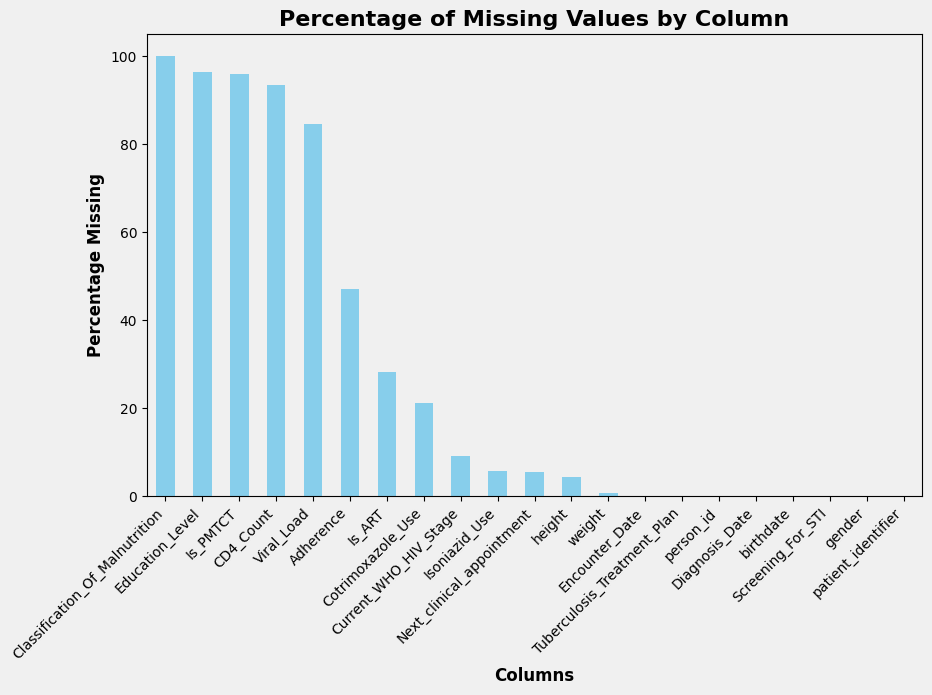

In [53]:
# Calculate the percentage of missing values for each column
missing_percentage = (ampath_patient_data_cleaned.isnull().sum() / len(ampath_patient_data_cleaned)) * 100

# Identify columns with a high percentage of missing values (e.g., >50%)
high_missing_columns = missing_percentage[missing_percentage > 50]

# Display the columns with their missing percentages
print("Columns with >50% missing values:")
print(high_missing_columns)



plt.figure(figsize=(10, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.show()


### Height (75,585 Missing Values)
#### Analysis
Height has 75,585 missing values. In adults, height is relatively stable across time, with minor variations typically due to measurement error or age-related changes. Missing values may occur due to clinicians skipping measurements when focused on more immediate health concerns.

#### Approach
1. **Within-patient temporal filling**:
   - For patients with at least one height measurement, use forward-fill followed by backward-fill to utilize temporally adjacent measurements.
   - This respects the biological reality that height remains relatively stable for adults.

2. **Demographic-based imputation for remaining patients**:
   - For patients with no height recorded, impute using median values stratified by gender and age groups.
   - This approach is supported by clinical literature on anthropometric imputation.

In [54]:
# Forward and backward fill height within each patient
ampath_patient_data_cleaned['height'] = ampath_patient_data_cleaned.groupby('person_id')['height'].transform(lambda x: x.ffill().bfill())

# Calculate age at encounter (handle invalid dates)
ampath_patient_data_cleaned['age_at_encounter'] = (
    (ampath_patient_data_cleaned['Encounter_Date'] - pd.to_datetime(ampath_patient_data_cleaned['birthdate'], errors='coerce'))
    .dt.days / 365.25
)

# Create age groups with corrected bins and handle missing values
bins = [0, 18, 30, 45, 60, 120]  # Added <18 category
labels = ['<18', '18-30', '31-45', '46-60', '61+']
ampath_patient_data_cleaned['age_group'] = (
    pd.cut(ampath_patient_data_cleaned['age_at_encounter'],
           bins=bins,
           labels=labels,
           right=False)  # Include left bin edge
    .cat.add_categories('unknown')
    .fillna('unknown')  # Handle NaN from invalid/missing dates
)
ampath_patient_data_cleaned['height'] = pd.to_numeric(ampath_patient_data_cleaned['height'], errors='coerce')

# Calculate median height by gender and age group (including 'unknown')
median_heights = ampath_patient_data_cleaned.groupby(['gender', 'age_group'])['height'].transform('median')

# Final imputation
ampath_patient_data_cleaned['height'] = ampath_patient_data_cleaned['height'].fillna(median_heights)

# Verify results
print("Missing values in age_group:", ampath_patient_data_cleaned['age_group'].isna().sum())
print("Missing values in height:", ampath_patient_data_cleaned['height'].isna().sum())


Missing values in age_group: 0
Missing values in height: 0


### Weight (14,171 Missing Values)

#### Analysis
Weight has 14,171 missing values. Unlike height, weight can fluctuate significantly over time due to disease progression, medication effects, and other health factors. In HIV treatment, weight changes can be clinically significant indicators of treatment efficacy.

#### Approach
1. **Linear interpolation within patients**:
   - For patients with at least two weight measurements, use linear interpolation to estimate weights between known measurements.
   - This accounts for the temporal trends in weight changes rather than assuming stability.

2. **Forward/backward fill remaining gaps**:
   - For dates beyond the range of available measurements, use forward and backward fill.

3. **Demographic-based imputation for remaining patients**:
   - For patients with no weight recorded, impute using stratified medians based on gender, age group, and HIV stage.

In [55]:
# Sort data for proper interpolation
ampath_patient_data_cleaned = ampath_patient_data_cleaned.sort_values(['person_id', 'Encounter_Date'])

ampath_patient_data_cleaned['weight'] = pd.to_numeric(ampath_patient_data_cleaned['weight'], errors='coerce')

# Linear interpolation within each patient
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned.groupby('person_id')['weight'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both'))

# Forward/backward fill remaining gaps
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned.groupby('person_id')['weight'].transform(
    lambda x: x.ffill().bfill())

# Stratified imputation for patients with no weight data
median_weights = ampath_patient_data_cleaned.groupby(['gender', 'age_group'])['weight'].transform('median')
ampath_patient_data_cleaned['weight'] = ampath_patient_data_cleaned['weight'].fillna(median_weights)

print("Missing values in weight:", ampath_patient_data_cleaned['weight'].isna().sum())

Missing values in weight: 0


## Feature Engineering: AMPATH PATIENT DATA

#### Patient Age at Scheduled Appointment
**Purpose**: Analyze age-related adherence patterns.
**Calculation**:  
`Age = (Next_clinical_appointment - birthdate).years`

In [56]:
ampath_patient_data_cleaned = pd.read_csv("data/AI_Predictive_Modeling_HIV_AMPATH_DataCleaning.csv")

# Create a new dataset for feature engineering by copying the cleaned dataset
ampath_patient_data_feature_engineering = ampath_patient_data_cleaned.copy()


# Convert 'birthdate' to datetime format
ampath_patient_data_feature_engineering['birthdate'] = pd.to_datetime(
    ampath_patient_data_feature_engineering['birthdate'], errors='coerce'
)

ampath_patient_data_feature_engineering["Next_clinical_appointment"] = pd.to_datetime(
    ampath_patient_data_feature_engineering["Next_clinical_appointment"].astype(str),
    errors="coerce",
)

# Calculate age at scheduled appointment
ampath_patient_data_feature_engineering['age_at_scheduled_appointment'] = (
    ampath_patient_data_feature_engineering['Next_clinical_appointment'] - ampath_patient_data_feature_engineering['birthdate']
).dt.days / 365.25

# print first five records showing patient id and patinet age


### Overall Appointment Success Percentage

 **Purpose:**  
This feature calculates the percentage of appointments successfully attended by a patient, providing a clear metric for adherence reliability.

 **Explanation:**  
The formula subtracts the number of past IITs (`num_past_iits`) from the total number of past encounters (`past_encounters`) and divides it by the total encounters to compute the success percentage:  

$$
\text{overall\_appointment\_success} = \left( \frac{\text{past\_encounters} - \text{num\_past\_iits}}{\text{past\_encounters}} \right) \times 100
$$  

- Patients with no past encounters default to **100% success**.  
- Patients with all IITs result in **0% success**.  

This feature helps identify reliable patients and those needing intervention.

In [57]:
# Calculate number of past encounters for each patient up to each encounter date
ampath_patient_data_feature_engineering['past_encounters'] = (
    ampath_patient_data_feature_engineering.groupby('person_id').cumcount()
)

# Sort by person_id and Encounter_Date (ensure Encounter_Date is datetime)
ampath_patient_data_feature_engineering['Encounter_Date'] = pd.to_datetime(ampath_patient_data_feature_engineering['Encounter_Date'], errors='coerce')
ampath_patient_data_feature_engineering['Next_clinical_appointment'] = pd.to_datetime(ampath_patient_data_feature_engineering['Next_clinical_appointment'], errors='coerce')
# Calculate days_diff_appt (if not already done)
ampath_patient_data_feature_engineering['days_diff_appt'] = (
    (ampath_patient_data_feature_engineering['Encounter_Date'] - 
     ampath_patient_data_feature_engineering['Next_clinical_appointment'].shift(1))
    .dt.days
)

# Create binary flag for IIT events
ampath_patient_data_feature_engineering['iit_flag'] = (
    (ampath_patient_data_feature_engineering['days_diff_appt'] > 28)
    .astype(int)
)

# Calculate patient-specific past IITs (corrected)
ampath_patient_data_feature_engineering['num_past_iits'] = (
    ampath_patient_data_feature_engineering
    .groupby('person_id')['iit_flag']
    .transform(lambda x: x.cumsum().shift(1).fillna(0))
    .astype(int)
)


# Function to calculate overall appointment success percentage
def calculate_appointment_success(df):
    # Avoid division by zero for new patients
    df['overall_appointment_success'] = (
        (df['past_encounters'] - df['num_past_iits']) / df['past_encounters'] * 100
    ).fillna(100)  # Default to 100% for new patients
    
    # Round to nearest integer for cleaner display
    df['overall_appointment_success'] = df['overall_appointment_success'].round()
    return df

# Apply the function to the dataset
ampath_patient_data_feature_engineering = calculate_appointment_success(ampath_patient_data_feature_engineering)


specific_person_id = ampath_patient_data_feature_engineering['person_id'].iloc[0] 

# Filter the dataset to display all rows for the specific person_id
filtered_data = ampath_patient_data_feature_engineering[ampath_patient_data_feature_engineering['person_id'] == specific_person_id]

# Display all instances of the specific person_id
print(filtered_data[['person_id', 'past_encounters', 'num_past_iits', 'overall_appointment_success']])


    person_id  past_encounters  num_past_iits  overall_appointment_success
0          46                0              0                        100.0
1          46                1              0                        100.0
2          46                2              0                        100.0
3          46                3              0                        100.0
4          46                4              0                        100.0
5          46                5              0                        100.0
6          46                6              0                        100.0
7          46                7              0                        100.0
8          46                8              0                        100.0
9          46                9              0                        100.0
10         46               10              0                        100.0
11         46               11              0                        100.0
12         46            

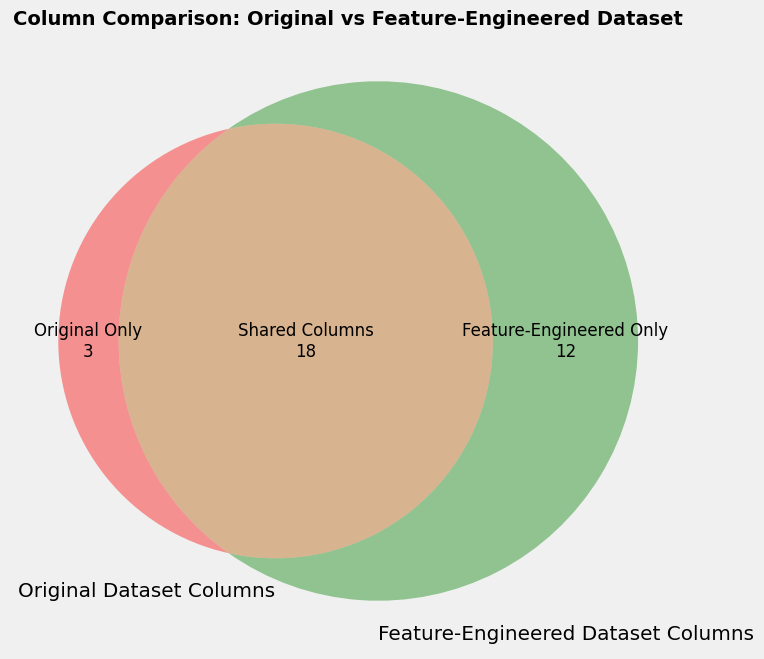

In [58]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Get the list of columns from both dataframes
original_columns = set(ampath_patient_data.columns)
feature_engineering_columns = set(ampath_patient_data_feature_engineering.columns)

# Create a Venn diagram
plt.figure(figsize=(10, 8))
venn = venn2(
    [original_columns, feature_engineering_columns],
    set_labels=('Original Dataset Columns', 'Feature-Engineered Dataset Columns')
)

# Add annotations for counts
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text(f"Original Only\n{len(original_columns - feature_engineering_columns)}")
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text(f"Feature-Engineered Only\n{len(feature_engineering_columns - original_columns)}")
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text(f"Shared Columns\n{len(original_columns & feature_engineering_columns)}")

# Add title
plt.title("Column Comparison: Original vs Feature-Engineered Dataset", fontsize=14)

# Show the plot
plt.show()


## Data Cleaning: KASHA DELIVERY DATA

#### Primary Phone No. and Secondary Phone No. with incorrect format
The Primary Phone No. and Secondary Phone No. columns store critical patient contact details, which are used for communication and delivery coordination.

**Issues Identified:**

1. Missing country code (e.g., 0712345678 instead of 254712345678).
2. Extra or missing digits (e.g., 25471234567 or 2547123456789).
3. Presence of non-numeric characters (e.g., 25475678SIZ).

**Analysis**

There are 784 fields with incorrect phone number format of '2547********'

**Approach**
1. Flag rows with incorrect formats for the **Primary Phone No.** and the **Secondary Phone No.** columns

2. Update the affected rows with 'unknown'

In [59]:
df = pd.read_csv("data/AI_Predictive_Modeling_HIV_AMPATH_KASHA_PatientData.csv")

def check_phone_format(phone):
    pattern = re.compile(r'^254\d{9}$')  # Format: 254712345678
    return bool(pattern.match(str(phone)))

df['Primary Phone No. Valid'] = df['Primary Phone No.'].apply(check_phone_format)
df['Seconday Phone No. Valid'] = df['Seconday Phone No.'].apply(check_phone_format)

invalid_primary_phone_count = df[df['Primary Phone No. Valid'] == False].shape[0]
invalid_secondary_phone_count = df[df['Seconday Phone No. Valid'] == False].shape[0]
print(f"Number of rows with incorrect Primary Phone No.: {invalid_primary_phone_count}")
print(f"Number of rows with incorrect Secondary Phone No.: {invalid_secondary_phone_count}")

Number of rows with incorrect Primary Phone No.: 23
Number of rows with incorrect Secondary Phone No.: 713


In [60]:
# Replace incorrect phone numbers with 'UNKNOWN'
df['Primary Phone No.'] = df['Primary Phone No.'].apply(lambda x: x if check_phone_format(x) else "UNKNOWN")
df['Seconday Phone No.'] = df['Seconday Phone No.'].apply(lambda x: x if check_phone_format(x) else "UNKNOWN")

# Check again after replacement
invalid_primary_after = df[df['Primary Phone No.'] != "UNKNOWN"].apply(lambda x: not check_phone_format(x['Primary Phone No.']), axis=1).sum()
invalid_secondary_after = df[df['Seconday Phone No.'] != "UNKNOWN"].apply(lambda x: not check_phone_format(x['Seconday Phone No.']), axis=1).sum()

print(f"Remaining invalid Primary Phone No. count after replacement: {invalid_primary_after}")
print(f"Remaining invalid Secondary Phone No. count after replacement: {invalid_secondary_after}")

Remaining invalid Primary Phone No. count after replacement: 0
Remaining invalid Secondary Phone No. count after replacement: 0


#### Missing County Values

The County column represents the geographical locations of patients, which are critical for accurate medication delivery logistics.

Analysis
- The dataset contains several rows where County values are missing.
- Since facility names are available, missing counties can be inferred from facilities that have known County values.

Approach
1. **Conditional imputation based on similar values such as facility**
   - Filling missing County values by checking other entries in the same Facility group.
   - If the Facility has at least one non-missing County value, use the most frequent County.
   - If all rows for a Facility have missing County values, set them to "UNKNOWN".


In [61]:
# Identify rows where County was missing before filling
missing_before = df[df['County'].isnull()].copy()

# Function to get the mode of each Facility or return "Unknown" if no mode exists
def get_mode_or_unknown(series):
    mode_values = series.dropna().mode()
    return mode_values[0] if not mode_values.empty else "Unknown"

# Fill missing County values based on the most frequent County within each Facility
df['County'] = df.groupby('Facility')['County'].transform(lambda x: x.fillna(get_mode_or_unknown(x)))

# Show only the rows that were updated with their new County values
updated_rows = df.loc[missing_before.index, ['Facility', 'County']].copy()
updated_rows.rename(columns={'County': 'Updated County'}, inplace=True)
display(updated_rows)

,Facility,Updated County
38,15204.0,UASIN GISHU
105,14947.0,TRANS NZOIA
421,15753.0,UASIN GISHU
653,12904.0,Unknown
854,16347.0,UASIN GISHU
938,15758.0,UASIN GISHU
988,14947.0,TRANS NZOIA
1020,14947.0,TRANS NZOIA
1028,15204.0,UASIN GISHU


## Feature Engineering: KASHA DELIVERY DATA

**1. Next Delivery Urgency**

**Purpose**: This groups deliveries into Overdue, Urgent, Upcoming, or Future for easier tracking

|Expected Next Delivery Date|Next Delivery Urgency|Urgency Level|
|---------------------------|---------------------|-------------|
|2025-04-15|19|Upcoming (8-30 days)|
|2025-03-30|3|Urgent (0-7 days)|
|2025-03-27|0|Overdue|
|2025-03-25|-2|Overdue|

In [62]:
patient_data_cleaned = pd.read_csv("data/AI_Predictive_Modeling_HIV_AMPATH_KASHA_PatientData.csv")
patient_data_feature_engineering = patient_data_cleaned.copy()

In [63]:
patient_data_feature_engineering['Expected Next Delivery Date'] = pd.to_datetime(
    patient_data_feature_engineering['Expected Next Delivery Date'], errors='coerce'
)

patient_data_feature_engineering['Next Delivery Urgency'] = (
    patient_data_feature_engineering['Expected Next Delivery Date'] - pd.Timestamp.today()
).dt.days

patient_data_feature_engineering['Urgency Level'] = pd.cut(
    patient_data_feature_engineering['Next Delivery Urgency'],
    bins=[-float('inf'), 0, 7, 30, float('inf')],
    labels=['Overdue', 'Urgent (0-7 days)', 'Upcoming (8-30 days)', 'Future (>30 days)']
)

# display(patient_data_feature_engineering[['Expected Next Delivery Date', 'Next Delivery Urgency', 'Urgency Level']])

**2. Consent Recency Category**

**Purpose:** Group patients based on how recently they consented.

| Category | Definition |
|----------|------------|
|Newly Consented|Less than 6 months|
|Recent|Between 6 months – 1 year|
|Long-Term|More than 1 year|


In [64]:
date_format = "%d/%m/%y %H:%M:%S"
patient_data_feature_engineering['Date Consented'] = pd.to_datetime(
    patient_data_feature_engineering['Date Consented'], format=date_format, errors='coerce'
)

patient_data_feature_engineering['Consent Tenure'] = (
    (pd.Timestamp.today() - patient_data_feature_engineering['Date Consented']).dt.days / 365
).round(2)

# Categorize Consent Recency
patient_data_feature_engineering['Consent Recency Category'] = pd.cut(
    patient_data_feature_engineering['Consent Tenure'],
    bins=[-float('inf'), 0.5, 1, float('inf')],
    labels=['Newly Consented (<6 months)', 'Recent (6 months - 1 year)', 'Long-Term (>1 year)']
)